In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import tqdm
import os
import re

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [2]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [3]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the images were pre-processed in another notebook, they must now be loaded into this one. To do so, we use a custom class taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [4]:
class prepped_data(Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

In [5]:
data_train = prepped_data('./content/train_loader/img', './content/train_loader/target')
data_test = prepped_data('./content/test_loader/img', './content/test_loader/target')

targets_train = [target for (_, target) in data_train]
targets_test = [target for (_, target) in data_test]

dataloader_train = DataLoader(data_train, batch_size=4, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=4, shuffle=False)

In [17]:
number_of_classes = 12

## Initialize models

### VGG16

In [6]:
model_vgg16 = torchvision.models.vgg16(weights="DEFAULT")

for param in model_vgg16.parameters():
    # As the model will not be trained, gradients are not required. Disabling
    # them speeds up performance.
    param.requires_grad = False

# Set model to evaluation mode for reasons
# TODO: Check why model should be set to evaluation mode
model_vgg16.eval()

# Empty CUDA cache to prevent memory issues
if cuda_enabled:
    torch.cuda.empty_cache()

# Replace VGG16 classifier with identity layer to allow descriptor extraction
model_vgg16.classifier = nn.Identity()

# Move model to previously set device, speeding up performance if CUDA-enabled
model_vgg16 = model_vgg16.to(device)

## Baseline

### Obtain image descriptors

In [7]:
def get_descriptors_from_model(model, dataloader):
    """Returns the output of the provided model for all items in the dataloader."""
    outputs = []

    # Improve performance by disabling unnecessary gradient calculation
    with torch.no_grad():
        for data, targets in tqdm.tqdm(dataloader):
            data = data.to(device)
            output = model(data).detach()
            outputs.extend(output)

    return outputs


def transform_descriptors_to_numpy(descriptors):
    """Returns a numpy array derived from a provided list of tensors."""
    return np.array([descriptor.cpu().numpy() for descriptor in descriptors])

In [8]:
extract = True

descriptors_vgg16_train = None
descriptors_vgg16_test = None

if extract:
    descriptors_vgg16_train = transform_descriptors_to_numpy(
        get_descriptors_from_model(model_vgg16, dataloader_train))
    with open('data/descriptors_vgg16_train.bin', 'wb') as file:
        pickle.dump(descriptors_vgg16_train, file)
    
    descriptors_vgg16_test = transform_descriptors_to_numpy(
        get_descriptors_from_model(model_vgg16, dataloader_test))
    with open('data/descriptors_vgg16_test.bin', 'wb') as file:
        pickle.dump(descriptors_vgg16_test, file)
else:
    with open('data/descriptors_vgg16_train.bin', 'rb') as file:
        descriptors_vgg16_train = pickle.load(file)
    with open('data/descriptors_vgg16_test.bin', 'rb') as file:
        descriptors_vgg16_test = pickle.load(file)

100%|██████████| 552/552 [00:14<00:00, 39.01it/s]


### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [9]:
n_neighbors_list = [2, 3, 5, 8, 13]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [10]:
classifier_vgg16_per_n = {}
predictions_vgg16_train_per_n = {}
accuracy_vgg16_train_per_n = {}
predictions_vgg16_test_per_n = {}
accuracy_vgg16_test_per_n = {}

for n_neighbors in n_neighbors_list:
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors
    ).fit(descriptors_vgg16_train, targets_train)
    classifier_vgg16_per_n[n_neighbors] = classifier

    predictions_train = classifier.predict(descriptors_vgg16_train)
    predictions_vgg16_train_per_n[n_neighbors] = predictions_train

    accuracy_train = accuracy_score(targets_train, predictions_train)
    accuracy_vgg16_train_per_n[n_neighbors] = accuracy_train

    predictions_test = classifier.predict(descriptors_vgg16_test)
    predictions_vgg16_test_per_n[n_neighbors] = predictions_test

    accuracy_test = accuracy_score(targets_test, predictions_test)
    accuracy_vgg16_test_per_n[n_neighbors] = accuracy_test

### Assess performance of kNN-classification for various values of n

We assess the accuracies calculated before.

Accuracy on training set for 2-neighbor classification: 0.9118
Accuracy on training set for 3-neighbor classification: 0.6175
Accuracy on training set for 5-neighbor classification: 0.4832
Accuracy on training set for 8-neighbor classification: 0.3832
Accuracy on training set for 13-neighbor classification: 0.3067
Accuracy on test set for 2-neighbor classification: 0.2882
Accuracy on test set for 3-neighbor classification: 0.2442
Accuracy on test set for 5-neighbor classification: 0.1926
Accuracy on test set for 8-neighbor classification: 0.1844
Accuracy on test set for 13-neighbor classification: 0.15


Text(0, 0.5, 'accuracy')

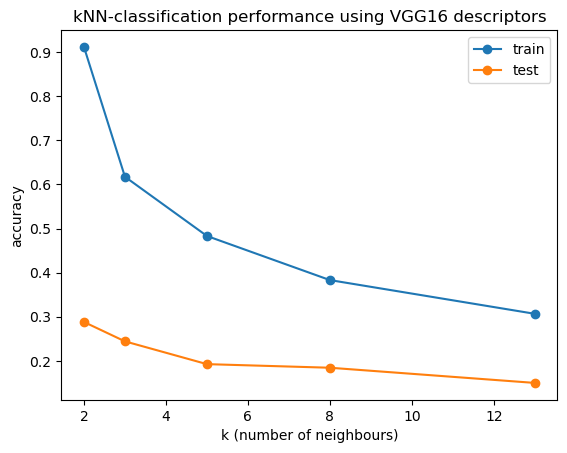

In [11]:
for n_neighbors in n_neighbors_list:
    train_accuracy = round(accuracy_vgg16_train_per_n[n_neighbors], 4)
    print(f"Accuracy on training set for {n_neighbors}-neighbor classification: {train_accuracy}")

for n_neighbors in n_neighbors_list:
    test_accuracy = round(accuracy_vgg16_test_per_n[n_neighbors], 4)
    print(f"Accuracy on test set for {n_neighbors}-neighbor classification: {test_accuracy}")

plt.plot(n_neighbors_list,
         list(accuracy_vgg16_train_per_n.values()),
         label="train",
         marker="o")
plt.plot(n_neighbors_list,
         list(accuracy_vgg16_test_per_n.values()),
         label="test",
         marker="o")
plt.legend()
plt.title("kNN-classification performance using VGG16 descriptors")
plt.xlabel("k (number of neighbours)")
plt.ylabel("accuracy")

The plot shows that the accuracy on the test set is quite stable, at a level just below 0.3. Meanwhile, the accuracy on the training set drops significantly as the number of neighbors is increased.

### Visually assess predicted vs. target through PCA

In [12]:
best_n_train = max(accuracy_vgg16_train_per_n, key=accuracy_vgg16_train_per_n.get)
best_n_test = max(accuracy_vgg16_test_per_n, key=accuracy_vgg16_test_per_n.get)

In [13]:
pca_train = PCA(n_components=2).fit_transform(descriptors_vgg16_train)
pca_test = PCA(n_components=2).fit_transform(descriptors_vgg16_test)

In [14]:
def plot_predictions_against_targets(data,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)

Text(0.5, 1.0, 'Two-component PCA, test data')

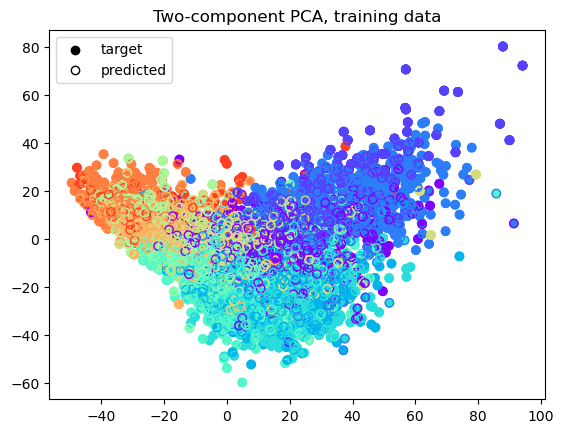

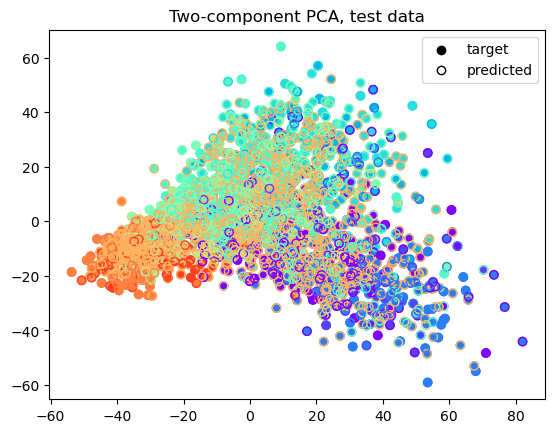

In [18]:
_, ax_train_scatter = plot_predictions_against_targets(pca_train,
                                                       predictions_vgg16_train_per_n[best_n_train],
                                                       targets_train,
                                                       number_of_classes)
ax_train_scatter.set_title("Two-component PCA, training data")

_, ax_test_scatter = plot_predictions_against_targets(pca_test,
                                                      predictions_vgg16_test_per_n[best_n_test],
                                                      targets_test,
                                                      number_of_classes)
ax_test_scatter.set_title("Two-component PCA, test data")